## Badanie wpływu dropout na wyniki sieci neuronowej

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import numpy as np

RESULTS_DIR = "results"

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### Wczytanie zbiorów danych

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

#### MNIST

In [4]:
mnist_train_transform = transforms.Compose(
    [
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

mnist_test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

In [5]:
set_seed(42)
mnist_train = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=mnist_train_transform
)
mnist_train_loader = torch.utils.data.DataLoader(
    mnist_train, batch_size=64, shuffle=True
)

mnist_test = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=mnist_test_transform
)
mnist_test_loader = torch.utils.data.DataLoader(
    mnist_test, batch_size=64, shuffle=False
)

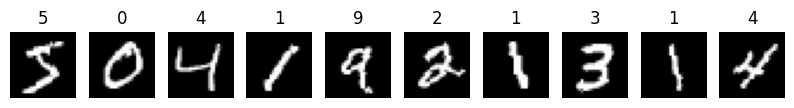

In [6]:
fig, axs = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    axs[i].imshow(mnist_train[i][0].squeeze(), cmap="gray")
    axs[i].set_title(mnist_train[i][1])
    axs[i].axis("off")

#### CIFAR

In [7]:
cifar_train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

cifar_test_transform = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

In [8]:
set_seed(42)
cifar_train = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=cifar_train_transform
)
cifar_train_loader = torch.utils.data.DataLoader(
    cifar_train, batch_size=64, shuffle=True
)

cifar_test = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=cifar_test_transform
)
cifar_test_loader = torch.utils.data.DataLoader(
    cifar_test, batch_size=64, shuffle=False
)

Files already downloaded and verified
Files already downloaded and verified


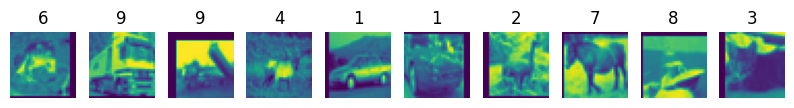

In [9]:
fig, axs = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    axs[i].imshow(cifar_train[i][0].permute(1, 2, 0))
    axs[i].set_title(cifar_train[i][1])
    axs[i].axis("off")

#### Model

In [10]:
class Model(nn.Module):
    def __init__(self, dropout_rate, input_size, hidden_sizes, output_size):
        super(Model, self).__init__()
        self.layers = nn.ModuleList()
        self.dropout = nn.ModuleList()

        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.dropout.append(nn.Dropout(dropout_rate))
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            self.dropout.append(nn.Dropout(dropout_rate))
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for layer, dropout in zip(self.layers[:-1], self.dropout):
            x = layer(x)
            x = dropout(x)
            x = torch.relu(x)
        x = self.layers[-1](x)
        return x

### Training loop

In [11]:
def train_step(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

In [12]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return running_loss / len(test_loader), correct / total

In [13]:
def train(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    max_num_epochs,
    early_stopping_patience,
    device,
):
    train_losses = []
    test_losses = []
    test_accuracies = []

    early_stopping = 0
    best_test_accuracy = 0
    for epoch in range(max_num_epochs):
        train_loss = train_step(model, train_loader, criterion, optimizer, device)
        test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
        print(
            f"Epoch {epoch + 1}/{max_num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}"
        )
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        if test_accuracy <= best_test_accuracy:
            early_stopping += 1
            if early_stopping == early_stopping_patience:
                print("Early stopping")
                break
        else:
            best_test_accuracy = test_accuracy
            early_stopping = 0

    return train_losses, test_losses, test_accuracies

### Experiments

In [14]:
from pathlib import Path
import json


def save_results(model, train_losses, test_losses, test_accuracies, path):
    Path(path).mkdir(parents=True, exist_ok=True)

    torch.save(model.state_dict(), f"{path}/model.pth")

    with open(f"{path}/train_losses.json", "w") as f:
        json.dump(train_losses, f)
    with open(f"{path}/test_losses.json", "w") as f:
        json.dump(test_losses, f)
    with open(f"{path}/test_accuracies.json", "w") as f:
        json.dump(test_accuracies, f)

#### MNIST

In [15]:
INPUT_SIZE = mnist_train[0][0].shape[1] * mnist_train[0][0].shape[2]
HIDDEN_SIZES = [64, 64]
OUTPUT_SIZE = len(mnist_train.classes)
DROPOUT_RATES = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

CRITERION = nn.CrossEntropyLoss()
OPTIMIZER = optim.Adam
LR = 0.0005

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MAX_EPOCHS = 100
EARLY_STOPPING_PATIENCE = 10

In [16]:
for dropout_rate in DROPOUT_RATES:
    set_seed(42)
    model = Model(dropout_rate, INPUT_SIZE, HIDDEN_SIZES, OUTPUT_SIZE).to(DEVICE)
    optimizer = OPTIMIZER(model.parameters(), lr=LR)
    train_losses, test_losses, test_accuracies = train(
        model,
        mnist_train_loader,
        mnist_test_loader,
        CRITERION,
        optimizer,
        MAX_EPOCHS,
        EARLY_STOPPING_PATIENCE,
        DEVICE,
    )
    save_results(
        model,
        train_losses,
        test_losses,
        test_accuracies,
        f"{RESULTS_DIR}/mnist/dropout_{dropout_rate}",
    )

100%|██████████| 938/938 [00:23<00:00, 39.83it/s]


Epoch 1/100, Train Loss: 0.5410, Test Loss: 0.2884, Test Accuracy: 0.9178


 11%|█         | 100/938 [00:02<00:22, 37.93it/s]


KeyboardInterrupt: 

### CIFAR

In [60]:
INPUT_SIZE = cifar_train[0][0].shape[1] * cifar_train[0][0].shape[2]
HIDDEN_SIZES = [128, 128, 128]
OUTPUT_SIZE = len(cifar_train.classes)
DROPOUT_RATES = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

CRITERION = nn.CrossEntropyLoss()
OPTIMIZER = optim.Adam
LR = 0.001

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MAX_EPOCHS = 100
EARLY_STOPPING_PATIENCE = 7

In [61]:
for dropout_rate in DROPOUT_RATES:
    set_seed(42)
    model = Model(dropout_rate, INPUT_SIZE, HIDDEN_SIZES, OUTPUT_SIZE).to(DEVICE)
    optimizer = OPTIMIZER(model.parameters(), lr=LR)
    train_losses, test_losses, test_accuracies = train(
        model,
        cifar_train_loader,
        cifar_test_loader,
        CRITERION,
        optimizer,
        MAX_EPOCHS,
        EARLY_STOPPING_PATIENCE,
        DEVICE,
    )
    save_results(
        model,
        train_losses,
        test_losses,
        test_accuracies,
        f'{RESULTS_DIR}/cifar/dropout_{dropout_rate.replace(".", "_")}',
    )

  0%|          | 0/782 [00:00<?, ?it/s]

 27%|██▋       | 209/782 [00:06<00:16, 34.55it/s]


KeyboardInterrupt: 